## ● Import modules

In [1]:
import sys

print("{}{: >25}{}{: >10}{}".format('|','Variable Name','|','Memory','|'))
print(" ------------------------------------ ")
for var_name in dir():
    if not var_name.startswith("_") and sys.getsizeof(eval(var_name)) > 10000: #ここだけアレンジ
        print("{}{: >25}{}{: >10}{}".format('|',var_name,'|',sys.getsizeof(eval(var_name)),'|'))

|            Variable Name|    Memory|
 ------------------------------------ 


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import random
# import tree_plot
from gbdt_funcs import *
from datetime import datetime
import math
from sklearn import model_selection
import pprint
from numba import jit

import lightgbm as lgb
from IPython.core.display import display, HTML
from sklearn.metrics import confusion_matrix
from matplotlib.patches import Rectangle
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from statistics import mean
from mpl_toolkits.mplot3d import Axes3D
import random
import matplotlib
from matplotlib.lines import Line2D

# import lime
# import lime.lime_tabular

import warnings
warnings.filterwarnings('ignore')

print("finished")

finished


/Users/susumu/.pyenv/versions/3.5.2/lib/python3.5/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


## ● Load essential data & remove unnecessary data

In [3]:
df = pd.read_csv("all.csv", escapechar="\\")

# remove spammers
df_spam = df[df["META:worker_id"].isin([75,77,36])]
df = df[~df["META:worker_id"].isin([75])]
# df = df[~df["META:worker_id"].isin([75,77,36])]
# remove microtasks that took too long to complete
df = df[~df["META:hit_id"].isin([19857,13414,19969])]
# remove microtasks that completed too fast
df = df[df["PHS:work_time"]>=3]
# Appends a number of submission in the same HIT group by the same worker
df_sc = pd.read_csv("submit_count.csv", escapechar="\\")
df = pd.merge(df,df_sc,on="META:hit_id")

### align the number of submissions of the top 3 HIT groups to that of the top 4
df_grpsize = df.groupby(["META:group_id","META:worker_id"]).size()
df = df[df["META:submit_count"]<sorted(df_grpsize,reverse=True)[4]]

df = df.rename(index=str, columns={"META:submit_count":"DASH:submit_count"})

df.loc[~df[["QTR:gender_Male","QTR:gender_Female","QTR:gender_Prefer_not_to_say"]].any(axis=1),"QTR:gender_Prefer_not_to_say"] = 1

# Delete other columns that aren't useful for data
# hit_id, worker_id, work_time will be removed from features later on
df = df.drop([
    "META:current_page",
    "META:next_action",
    "REP:requester_name",
    "PHS:work_time_type",
    "META:manifest_version",
    "META:time_all",
    "META:time_focus",
    "META:time_user",
    "REP:created"
], axis=1)
df = drop_contains(df, ["META:total_work_time","PHS:ans","Unnamed:"])
df = drop_contains(df, ["REP:tv","REP:to2"])

print("Only-eval columns:")

eval_cols = ["META:hit_id","META:worker_id","META:group_id","PHS:work_time"]
pprint.pprint(eval_cols)
df_eval = df[eval_cols]

print("Feature columns:")

df = df.drop(eval_cols, axis=1)
print(list(df.columns))
print(len(df.columns))

categorical_features = ["META:template","QTR:gender","QTR:employment_status"]

print("finished")

Only-eval columns:
['META:hit_id', 'META:worker_id', 'META:group_id', 'PHS:work_time']
Feature columns:
['TXT:title', 'TXT:description', 'META:duration_sec', 'META:reward', 'META:hits_available', 'META:template', 'TXT:inner_html', 'URL:text_url_counts', 'URL:a_href_counts', 'URL:all_url_counts', 'URL:qualtrics_url_counts', 'URL:img_src_counts', 'URL:audio_src_counts', 'URL:video_src_counts', 'INP:hidden', 'INP:submit', 'INP:text', 'INP:radio', 'INP:checkbox', 'INP:range', 'INP:button', 'INP:file', 'INP:number', 'INP:password', 'INP:url', 'INP:date', 'INP:time', 'INP:email', 'INP:reset', 'INP:tel', 'INP:select_option', 'INP:textarea', 'REP:to1_comm', 'REP:to1_pay', 'REP:to1_fair', 'REP:to1_fast', 'REP:to1_reviews', 'REP:to1_tos', 'EXT:auto_refresh', 'EXT:crowdworkers', 'EXT:distill', 'EXT:mturk_suite', 'EXT:openturk', 'EXT:page_monitor', 'EXT:tampermonkey', 'EXT:turkopticon', 'QTR:earnings_per_hour', 'QTR:weekly_work_hours', 'QTR:worker_experience', 'QTR:age', 'QTR:school_level', 'QTR:h

## ● Preprocess

In [4]:
df = preprocess(df)

print("Feature columns:")

pprint.pprint(list(df.columns))
print(len(df.columns))

print("finished")

Feature columns:
['DASH:approval_rate',
 'DASH:approved',
 'DASH:submit_count',
 'DASH:total_earnings',
 'EXT:auto_refresh',
 'EXT:crowdworkers',
 'EXT:distill',
 'EXT:mturk_suite',
 'EXT:openturk',
 'EXT:page_monitor',
 'EXT:tampermonkey',
 'EXT:turkopticon',
 'INP:button',
 'INP:button_perc',
 'INP:checkbox',
 'INP:checkbox_perc',
 'INP:date',
 'INP:date_perc',
 'INP:email',
 'INP:email_perc',
 'INP:file',
 'INP:file_perc',
 'INP:hidden',
 'INP:hidden_perc',
 'INP:number',
 'INP:number_perc',
 'INP:password',
 'INP:password_perc',
 'INP:radio',
 'INP:radio_perc',
 'INP:range',
 'INP:range_perc',
 'INP:reset',
 'INP:reset_perc',
 'INP:select_option',
 'INP:select_option_perc',
 'INP:submit',
 'INP:submit_perc',
 'INP:tel',
 'INP:tel_perc',
 'INP:text',
 'INP:text_perc',
 'INP:textarea',
 'INP:textarea_perc',
 'INP:time',
 'INP:time_perc',
 'INP:url',
 'INP:url_perc',
 'KW:answer',
 'KW:bonus',
 'KW:click',
 'KW:comment',
 'KW:comprehension',
 'KW:copy',
 'KW:description',
 'KW:design'


## Prepare GBDT params



In [177]:
def pwt(Y,err_pn,K=100):
    if err_pn=="pos":
#         [a,b,c] = [  360.95377102,   488.79287651, -2228.05521845]
#         [a,b,c] = [  418.05739494,   887.65102369, -2739.46462324]
        [a,b,c] = [  379.85367696,   572.53444962, -2389.95566413]
    elif err_pn=="neg":
        [a,b,c] = [ 137.78235923,  124.37127684, -587.36784393]

#     f = lambda x: (np.exp(-c/a)*K*expi(np.log(x+b)+c/a))/a if (np.exp(-c/a)*K*expi(np.log(x+b)+c/a))/a>0 else 0
    f = lambda x: (np.exp(-c/a)*K*expi(np.log(x+b)+c/a))/a if err_pn=="neg" else ((np.exp(-c/a)*K*expi(np.log(x+b)+c/a))/a+566.43445622221 if x>60 else K*np.log(x))
    
    return np.frompyfunc(f, 1, 1)(Y)

@jit
def myfobj(preds, train_data):
    y_preds = preds
    y_tests = train_data.label.values
    error_sec = y_preds-y_tests
    residual = np.where(error_sec>=0,pwt(y_tests,"pos")-pwt(y_preds,"pos"),pwt(y_tests,"neg")-pwt(y_preds,"neg"))
#     residual = pwt(y_tests,"neg")-pwt(y_preds,"neg")
    grad = -2*residual
    hess = 2*np.ones(grad.shape)
    print(np.nansum(residual))
    return grad,hess

@jit
def myfeval(preds, train_data):
    y_preds = preds
    y_tests = train_data.label.values
    error_sec = y_preds-y_tests
    residual = np.where(error_sec>=0,pwt(y_tests,"pos")-pwt(y_preds,"pos"),pwt(y_tests,"neg")-pwt(y_preds,"neg"))
#     residual = pwt(y_tests,"neg")-pwt(y_preds,"neg")
    return np.nansum(residual)

cv = 4
kf = model_selection.KFold(n_splits=cv,shuffle=False)

# objective = "multiclass"
objective = "regression"

### effective only for regression
# enc_method = "log10"
# enc_method = "log"
# enc_method = "psycho"
enc_method = ""

lgbm_params = {
#     'boosting': 'dart',
    'objective': objective,
    'metrics': "mse",
    'verbosity': 0,
    'learning_rate': 0.1,
    'categorical_feature': "name:META:template,QTR:employment_status,QTR:gender",
    'num_iterations': 400,
    'num_leaves': 31,
#     'drop_rate': 0.15
}

# drop_group_duplicates = True
drop_group_duplicates = False


# if drop_group_duplicates:
#     df_ = df.drop_duplicates("META:group_id")
    
print("objective: {}, enc_method: {}, drop_grp_duplicates: {}".format(objective,enc_method,drop_group_duplicates))


### make working time categories
# work_time_upper = [8,15,30,45,60,90,120,150,180,240,300,420,600,1200]
# work_time_upper = [8,15,30,45,60,80,100,120,140,170,200,240,280,340,420,600,800,1200]
# work_time_upper = [30,60,120,180,300,600,1200]
# work_time_upper = [60,180,300,600,1200]
# work_time_upper = [30, 90, 240, 450, 690, 960, 1260,1590,1920]
# work_time_upper = [60, 180, 360, 630, 960, 1350, 1770, 2220, 2700]
# work_time_upper = [60, 180, 390, 660, 990, 1350, 1740, 2160, 2610]
work_time_upper = [60, 180, 360, 600, 900, 1260, 1650, 2070, 2520]
# work_time_upper = [60, 150, 300, 510, 780, 1110, 1500, 1920, 2370]
cls = []
for i,t in enumerate(work_time_upper):
    if i==0:
        work_time_min = ""
    else:
        work_time_min = work_time_upper[i-1]
    work_time_max = t
    cls.append("{}-{}".format(work_time_min,work_time_max))
cls.append("{}-".format(work_time_upper[-1]))
if objective=="multiclass":
    lgbm_params["num_class"] = len(cls)
    
print(cls)

reward_upper = [0.75,1.5,2.5,4,6,8,10,15,20,25,30]
r_cls = []
for i,t in enumerate(reward_upper):
    if i==0:
        reward_min = ""
    else:
        reward_min = "${}".format(reward_upper[i-1])
    reward_max = "${}".format(t)
    r_cls.append("{}-{}".format(reward_min,reward_max))
r_cls.append("${}-".format(reward_upper[-1]))
    
print(r_cls)

# r_categories = [
#     ("-$2.00", 2),
#     ("$2.00-$4.00", 4),
#     ("$4.00-$6.00", 6),
#     ("$6.00-$8.00", 8),
#     ("$8.00-$10.00", 10),
#     ("$10.00-$15.00", 15),
#     ("$15.00-$20.00", 20),
#     ("$20.00-", 9999)
# ]


objective: regression, enc_method: , drop_grp_duplicates: False
['-60', '60-180', '180-360', '360-600', '600-900', '900-1260', '1260-1650', '1650-2070', '2070-2520', '2520-']
['-$0.75', '$0.75-$1.5', '$1.5-$2.5', '$2.5-$4', '$4-$6', '$6-$8', '$8-$10', '$10-$15', '$15-$20', '$20-$25', '$25-$30', '$30-']


## \[Only for export\] Train & export GBDT model

[-4.251998926991803 -4.083681823132963 -4.551690817939928 ...
 -6.698353644026412 -6.632600923131719 -7.323065952895831]
[-3.382761614931397 -3.2817958710946016 -3.742557888708646 ...
 -5.955863364698942 -5.823467993900437 -6.453828640835425]
[-2.6036443895261385 -2.614079819333597 -3.0081026977127294 ...
 -5.367603482944901 -5.172262417149739 -5.773227692129183]
[-1.9323597305022844 -1.99474412017031 -2.4449809733023216 ...
 -4.741007969622046 -4.546113366389662 -5.101579487037327]
[-1.3899969828386531 -1.4198823745901166 -1.9125745464292407 ...
 -4.208164655669719 -4.013647822568387 -4.5746794850974055]
[-0.859365354154491 -0.9620377928957282 -1.441704197882828 ...
 -3.736909584118223 -3.542725415428791 -4.094044983401531]
[-0.40852886278524636 -0.5365153611808609 -1.0108632135189737 ...
 -3.3657134548621173 -3.12871172859559 -3.642804706479936]
[-0.02883649262773247 -0.1341995879613478 -0.5164330369600378 ...
 -3.012072243874769 -2.7754017588193562 -3.2124677735634037]
[-2.530018351

[-2127.842228462847 -2129.4739692618077 -2204.520226025532 ...
 -2258.008316549164 -2258.6535839855123 -2249.727666077914]
[-2157.328066024471 -2158.9598047366694 -2234.0034729777194 ...
 -2287.710502959866 -2288.3550805589534 -2279.465535790347]
[-2186.778363917895 -2188.410100637995 -2263.469499224505 ...
 -2317.4069514185603 -2318.0508671328143 -2309.1962187226836]
[-2216.200627650756 -2217.8323624668537 -2292.9247124363937 ...
 -2347.1034568576847 -2347.746736886948 -2338.925600840342]
[-2245.601899425948 -2247.2336324201674 -2322.3751488835196 ...
 -2376.805492362153 -2377.4481612984687 -2368.659238724108]
[-2274.9887976011214 -2276.6205288501455 -2351.8265040559854 ...
 -2406.5182345988087 -2407.160315556558 -2398.402385763656]
[-2304.367552222434 -2305.999281797979 -2381.284160148589 ...
 -2436.2465869476073 -2436.8881016807445 -2428.1600159620943]
[-2333.744036627464 -2335.3757645967025 -2410.7532094699377 ...
 -2465.995199904207 -2466.636168912095 -2457.9368449328267]
[-2363.1

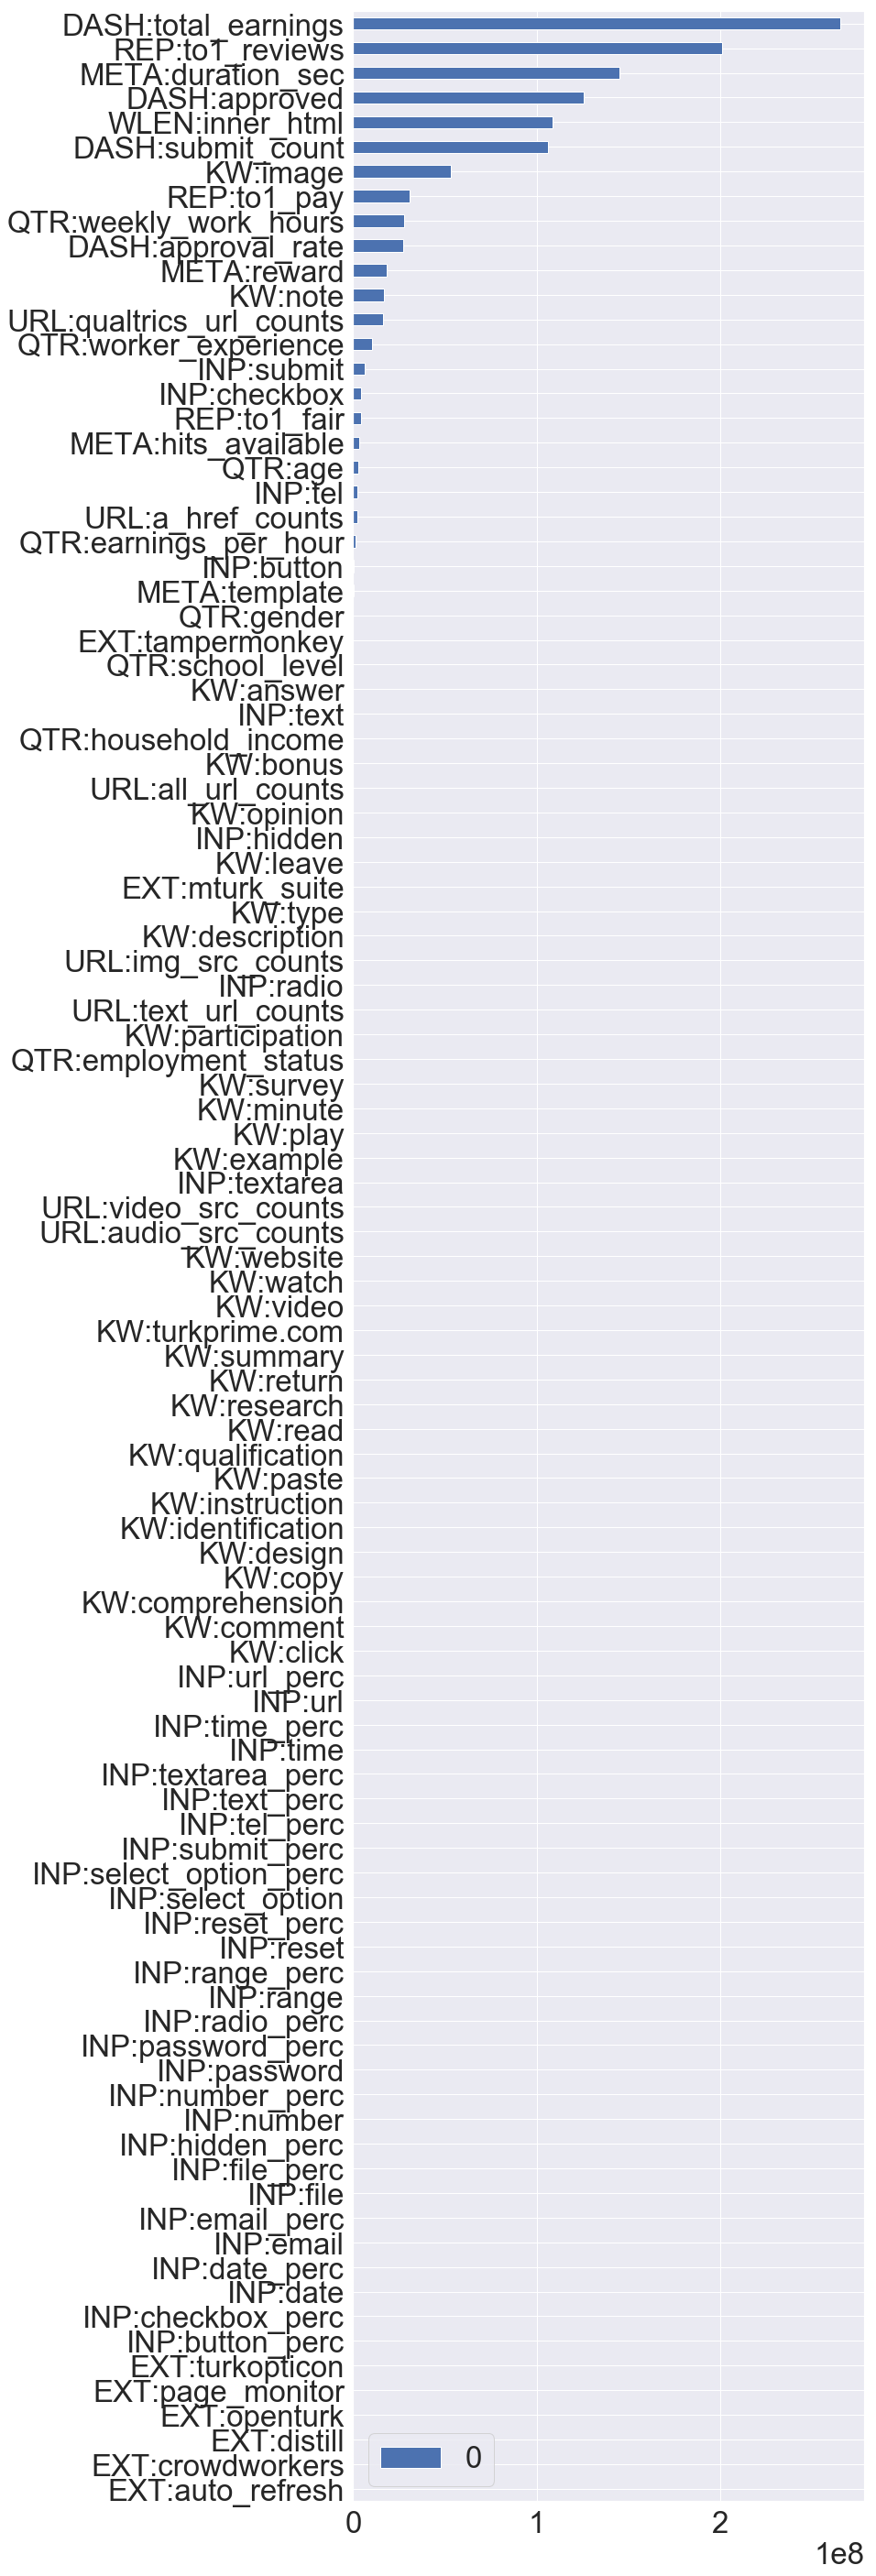

In [26]:
import datetime
import operator

X = df
y = df_eval["PHS:work_time"].apply(lambda x: encode_val(x,enc_method))

lgb_dataset = lgb.Dataset(data=X, label=y, free_raw_data=False)
model = lgb.train(lgbm_params, lgb_dataset, valid_sets=lgb_dataset, verbose_eval=False, categorical_feature=categorical_features, fobj=myfobj)

feature_importance = sorted(list(zip(*(model.feature_importance(importance_type="gain"),X.columns))))
df_feature = pd.DataFrame([f[0] for f in feature_importance],index=[f[1] for f in feature_importance])
df_feature.plot.barh(figsize=(10,50))

# X_ = X.copy()
# X_["work_time"] = y

# X_.to_csv("training_data.csv")

# importance_type="gain"
# feature_importance = model.feature_importance(importance_type=importance_type)

# sns.set(font_scale=2.5)
# ax = lgb.plot_importance(model, max_num_features=20, figsize=(12, 20), importance_type=importance_type, precision=0)
# plt.plot()

# df_fi = pd.DataFrame({"name": X.columns, "importance": feature_importance}).sort_values("importance",ascending=False)
# print("=== Feature importance ranking (desc, {})===".format(importance_type))
# print(df_fi.loc[df_fi["importance"]>0,"name"].values.tolist())
# model_name = "lightgbm_model_{}_{}_{}.txt".format(objective,importance_type,datetime.datetime.now().strftime('%Y%m%d%H%M%S'))
# model.save_model(model_name)
# print(model_name)

In [30]:
if objective=="multiclass":
    mode = "classification"
else:
    mode = objective

explainer = lime.lime_tabular.LimeTabularExplainer(X.values, training_labels=y, feature_names=list(X.columns),
                                                   class_names=['working_time'], mode=mode,
                                                   categorical_features=categorical_features,
                                                   categorical_names=[get_categories(c) for c in categorical_features],
                                                   random_state=1)

def predict(X):
    y = model.predict(X, num_iteration=100)
    return y

print(df_spam[df_spam["META:hit_id"].isin([24512,802,859,929,12511376,1579,2066,2149,2336,2359,3223,3262,3306,1985,375])].index)

# print(X)
print(df_spam.loc[df_spam["META:hit_id"].isin([3262]),["PHS:work_time"]])

exp = explainer.explain_instance(X.values[5257], predict, num_features=20)
exp.show_in_notebook(show_table=True)

y_pred = exp.predicted_value
lime_results = {explainer.feature_names[t[0]]:t[1] for t in exp.local_exp[1]}

# print(y_pred)
# print(lime_results)

Int64Index([2093, 5246, 5247, 5248, 5251, 5252, 5253, 5254, 5255, 5256, 5257,
            5258],
           dtype='int64')
      PHS:work_time
5257        675.197


ValueError: could not broadcast input array from shape (2,101) into shape (2)

In [ ]:
# df["WLEN:inner_html"]

## Train & test model

objective: regression, enc_method: , drop_grp_duplicates: False
iteration 0
643674.1424656238
567144.9807335299
509512.03095889697
460903.3067544083
421309.6645894299
387795.2546861741
358671.70938027115
333752.50994023704
309827.4923967804
290822.0517503045
272653.02345299564
254502.92448982035
240917.11708788015
227018.12311129662
212932.70171463003
201488.8518544205
189239.02359569972
179586.55557779653
168342.0219994722
160993.14619044846
152228.91069317437
144576.88322111857
137624.45580587056
131984.68105932183
125745.42659922245
119360.10856316873
113989.36952486755
107930.80583858745
102482.68670461608
98393.9593200087
94230.72547457412
89620.79687572189
86304.56038988572
81841.51531129333
78393.00623150312
74704.8958940977
72064.2274895737
68824.43359694019
66535.47220237106
63507.66094343905
60921.37537221818
58184.96457886506
56277.05835431783
54803.66778378331
52791.86026495961
51054.15535025895
49620.083617436605
47496.31800799903
45360.92246464302
43687.32106771658
42423.

77014.69960076899
73549.73196399468
71681.31807111211
69011.87941767239
67263.72516498141
65288.30039403691
63582.56646033201
61365.394319221916
58809.604413645124
56034.663140909644
53876.94360677924
52191.70378168095
50883.1783244119
48188.536473153436
46603.09010287116
44249.660819973935
44562.092772073105
43130.32688674845
41929.95799874932
40433.151865575135
38766.954553155236
37448.198423336566
37157.52249347304
35128.59445041687
33387.29342400944
33381.780764759555
32397.890456787678
31136.943626572014
29821.64377819088
29871.182448095038
28907.13895010245
27667.44167989146
26619.950348507828
26042.065378500127
25498.30811531029
25296.733568505126
24853.255783152046
23852.399757119863
22796.573234924974
22093.667209397838
22106.040424607494
21577.405681250842
21273.872135423087
20891.943311712494
20135.565489655208
20476.804454628145
20388.757904751175
19839.175974523543
19193.925861292577
19211.869636313397
18633.46117146722
17848.20252263421
17483.37754607321
17399.88837524293

21298.10530642516
20085.27225864572
19714.317556464135
18848.852288834183
18932.95012179588
18933.122481280257
18790.849031790123
18772.219362404154
18704.868851394884
18361.42647529562
17660.273835840013
17589.91116864243
17452.965956113167
17118.38502505921
16378.138470498112
15946.450073346283
15375.514265932532
15244.834843525936
14663.380346164864
14668.270766764208
14757.58969666647
14504.801919036066
14101.257590808433
13932.023630846976
13880.136927117303
14088.94215927533
14026.113717046766
13677.130532217245
13350.245345328238
12741.71504836462
12381.048318148387
11659.470573234215
11822.697505368684
11771.857099424986
11277.325472697585
10770.831761861986
10926.636676443366
11209.141752942402
11295.864558015519
10742.907031747518
10633.702123444993
10586.109747120116
10722.01796166999
10947.358650458693
10736.542239641094
10517.152170003128
10699.33751364436
10640.228654939334
10592.42538586791
10533.636115697554
9700.16559980926
9841.37116449879
9715.092710229948
9490.29025

9309.750373395666
8805.014954946257
8828.865516145996
8440.766184806349
9074.348009116711
9160.181573061931
8619.450622481834
8624.732965123805
7923.46382682978
8143.454560899601
8369.537417082847
8420.507245022942
8162.297009948615
8500.97133621513
8144.335726677215
8097.031642242839
7898.8001460021815
8135.9494145270355
7727.3792511547435
7707.373530082622
7926.640843259056
7925.792853592061
7376.033427506378
7061.648716062113
6536.93108423953
6343.777821787964
6589.65275297912
6252.778794218474
6072.23564107207
5925.262360514036
5689.191972995125
6249.255285746567
6184.299577125548
5907.4892605077275
5598.847726875748
5483.196382235897
5875.065696744249
6229.393668533014
6130.124065496118
6068.59057043681
5914.443055448799
5826.106962374926
5593.75082600945
5136.619978079758
5139.834871050018
5052.5166390885615
5166.738244109349
5225.89132318971
5394.240320715731
5592.610530588913
5098.57160915549
5380.118802101493
5605.785859806758
5381.72528793871
5393.273609795161
5003.4082291061

4144.529926433281
4105.840430586411
4002.937935867062
3825.397988484546
3997.94034870265
4114.113194721189
3694.1925814962124
3555.1326437680673
3298.9850739852573
3201.393404823255
3341.817901477107
3192.374209291096
3041.879852887231
2956.731526411388
2945.9136058036556
3324.0506839304844
3502.8549708333085
3350.735973665798
3246.1355547871763
3539.508178864098
3524.1659505936213
3142.9997947827796
3055.5855155597164
3440.217608054967
3151.6334139391315
3207.1976608008135
3362.0302254761355
3143.6749900343116
3260.0515969403505
3323.091695890744
3151.7017273286
3193.1767126852824
2994.42935955923
2925.6449923515615
2832.795665455278
2962.7433514977392
2847.045026488117
2992.9030564282066
2863.4119387593455
2905.436904094737
2820.9964456661455
2940.161237815532
2942.638345786615
3076.2644697701394
3223.315731032589
3199.2782148548213
3015.2633431203813
3056.005367947716
2736.76027913536
2551.398788408998
2343.6934376131576
2333.8654694526026
2400.974366762085
2289.0782707385115
2422.1

4041.2953864346387
4060.132331294094
4121.277894880623
3792.4789702300586
3598.507528276529
3525.9846924305457
3507.029228825726
3543.3869433863492
3329.9631783987893
3353.121513768989
3107.3334663482997
3254.2454345068854
3383.111095725931
4079.846440381421
4025.660127525687
3982.308456433772
3596.44180463426
3416.935391432785
3286.381154359491
3269.2834043365747
3408.455596346307
3394.4989536344397
3456.381531447982
3434.7914446760287
3457.1750207583727
3534.1244643378514
3474.908314799642
3480.393379421101
3452.433963117743
3523.287030151876
3378.0851515199884
3530.6113584751606
3301.8892102199816
3372.7966029295417
3274.9573819260427
3373.385454193941
3535.795207892802
3625.0021482252873
3549.970925875179
3553.792271645001
3448.177309531158
3179.5629706851796
3259.5935139790195
3282.0182485680116
3170.941662052818
2889.0324412946948
2773.178355127181
2997.8996247165364
2749.233696619048
2693.2323236722063
2608.8226824737617
2491.593413617488
2755.5926543200376
2659.690987997618
218

3358.3739228156014
3267.6983889147273
3168.201258490729
3272.943677287228
3515.7758963986607
3604.8633562761015
3488.1703917048144
3271.9880976551353
3174.9895586443554
2993.6184126835315
3186.7269090143022
3429.0065905030788
3374.3104634207175
3140.1858635408757
2956.982342425512
3379.422791532903
3112.8534680407142
2938.8023631061933
2747.0363619301584
2922.5140307197344
2950.763578720671
2755.735619021332
2782.400206005766
2732.7869739715893
2621.5287096145926
2462.448158630366
2556.811548606308
2634.3674696882713
2661.8334522239043
2629.850910431688
2587.1037475428793
2671.3406107799337
2849.4567648747693
2613.549291492526
2538.8146738948435
2853.7738272118604
2622.5315473528776
2535.9374471980927
2477.576720415746
2562.4054003952365
2469.0982045478963
2242.1479104744008
2209.9779064867234
2379.775495284676
2531.706907776892
2578.6071708217187
2681.0253659828454
2718.439515159057
2444.9054636817946
2364.84206610325
2092.010114198498
2356.3767741015067
2477.796988109766
2474.2410185

2565.9619162366257
2482.763746088181
2273.6006393001567
2230.424771124569
2084.6346048571313
2410.244472930685
2424.801791949228
2276.5374447236773
2636.079461674518
2473.6440783929384
2593.8895199997405
2675.685056533653
2433.921256070042
2387.7670902518817
2383.7183115791586
2449.2337978969545
2463.450251999051
2518.0204350898975
2348.4942686927834
2305.1095400379995
2358.4843959246123
2209.9288398486447
2352.197703975083
2359.6288400873386
2250.8646628051215
2215.2205560368207
2131.0036738241893
2330.263971996427
2544.872209735163
2668.0953158710868
2535.7655599497425
2525.0868685427363
2277.4642519815807
2222.1458697333633
2376.9834990004783
2434.561950536164
2133.497635359356
2216.9592272704917
2100.84141896921
2033.537596261369
2077.102078723721
1926.698223776098
2039.4262143871197
2285.079244498117
2161.1059682462246
2087.035963913107
1967.8534464282159
1956.0301444641227
2003.4657325853148
2043.5059142606765
2065.206891558595
1993.5313093623754
1975.051461839419
2058.9960502584

1611.9756158457853
1701.5280127594951
1729.2771449736538
1649.6470576676375
1552.4620009336704
1471.7255816658283
1339.360509169533
1347.8061622245925
1484.0688145438828
1418.5073648695022
1446.0465501279643
1470.9403321178277
1431.1270044210373
1500.2080618877299
1486.438860456327
1420.6788978332693
1286.5576282843094
1335.903005109322
1326.553237396132
1429.1321076034415
1444.1899394238912
1301.7250544186272
1231.793553609748
1402.5990655921678
1523.3848898207814
1377.9233366017224
1381.9693121863513
1408.5632317628917
1437.3607287209086
1481.8293188058706
1495.899477405541
1360.6989257683613
1328.5322513516726
1159.098000961863
1351.5375973232387
1362.5725514069534
1500.4925278355736
1590.5634166755988
1507.8966691052933
1309.4930745907104
1244.2734372256743
1370.35283949942
{}
815562.2531125143
717487.4718858729
643763.0459636565
582549.718417077
533382.359881245
491907.64293321257
453791.8896630057
420580.6932056566
390412.2052055141
366978.0233992334
341848.81484004145
319513.454

725922.5390034609
657985.6103599358
604880.9443891012
557586.9580550744
517683.7708241313
480391.87013751105
450251.7246802821
420548.1320123368
394633.6871136291
371798.51991703874
348894.0139453937
329519.2458263322
311230.1067806725
295158.48495746666
280691.31722575444
263194.4255686867
250035.75054602258
238052.52288779774
224402.66449595673
213791.090598763
201953.2293120006
191256.5383284693
183379.97455804815
174929.42929582344
168747.41539997875
160109.7130504678
152509.33479863848
146272.90606416797
139257.40049071237
132347.92388593676
126954.15433201702
122236.89413139543
116198.07284008405
111956.89824443129
107554.52031213383
103339.87129289443
98846.15092797481
95714.14205812936
91162.11989226713
88137.49134923118
84111.42552386592
79452.86598402014
77337.80941480347
73359.08431674635
71746.11745953643
68752.67342754416
65323.827031819645
63270.77050255038
61962.41272696833
60645.400366074995
57373.520437940555
54688.84056367209
54134.14634660792
51406.67996968246
49025.

66521.16492091483
64936.45020712618
61884.82564134827
59096.439307845474
56228.52543851927
53804.5870645682
53152.32820259558
51938.65935831463
50007.8257097265
48462.63996759692
46087.275213915724
45045.19112944311
43639.79181290459
41526.0047480127
40243.57724908312
38275.34829839757
36717.300169979
35195.21084470468
34547.715121777765
34706.365805552145
33407.998344644606
33220.05280435561
31802.044905053797
30457.21499078707
30827.424036189193
29339.085333807125
29042.561245764286
27788.61966022478
27040.44495874721
25853.47851236538
25423.530955418
25473.771062178235
24678.76508975377
23644.46569869327
23144.48921997752
22168.012307394823
21480.068025347966
21009.27685268313
20776.816392949706
19830.065842755317
19441.99106764105
20132.270047525893
20007.50377237596
19305.411780890758
19037.79834544503
18512.34520114112
18140.676420979606
17632.85977671868
17295.635581060844
17854.4925150687
18034.439762614238
18164.618370276134
17972.829277304183
17735.54310344067
17532.328704769

13531.380035008771
13142.344768701132
12409.852347248885
12654.263693361627
12433.569110811106
12227.744281720617
11536.68964655343
11073.01475629264
10899.934169469061
10699.36484137887
10489.843666287881
10512.849548958893
10507.168056976956
10465.702793806993
10522.05816603998
10389.884035017425
10573.615505074693
10068.132969270257
10081.07278319217
9959.364397484576
9699.760743723135
9613.369868558737
9249.666201777354
9127.150369752158
9078.799560038855
9049.443905746386
8960.53135837072
8931.771970601061
8452.920511076903
8001.374682656823
7738.739636497935
7870.508194008024
7512.0244102174565
7570.329762950659
7927.428142380308
7538.845828194281
7416.677913754767
7193.590029837189
7070.475670574572
6974.625066625129
6586.6696578585725
6197.034663169606
6427.667537909619
6669.504536416022
6396.305308053008
6338.137660742755
6089.683731089186
5798.630611218105
5674.473753668133
5698.833273289067
5994.241717303504
5898.488663912553
5999.241494414889
5865.779965450632
5786.60025545

9357.051131708904
9241.082124122087
9074.636332846254
9038.4459175362
8800.540367360285
8453.64649182111
8362.882704404896
8536.148428091836
8036.263073400988
8554.471821839486
8504.677985323484
8212.38809930586
8312.04670938354
8059.435074260226
8019.174801774802
7562.590512411717
7435.796219918097
7009.576762415577
6971.820169093117
7097.499558266191
6935.887425500877
7365.1681696530095
7203.251641156455
6884.718038317865
6981.468655155399
6606.298679768382
6632.6560538139465
6671.213589548858
6251.823453429467
6188.9563328497
6003.1860829399
5661.471814940948
5661.4995099263115
5481.837652032961
5450.355160166209
5581.8083368603475
5261.0377062032385
5259.43875349146
5264.474666701155
5326.406699798864
5335.283290101592
5094.931069712359
5108.998750308587
4936.985950724415
4805.391029721311
4860.113581775986
4804.089303792574
5052.810778024272
5218.546992223751
5084.052243386958
5219.399929676663
5151.789641461869
5221.369923306619
5275.370250686223
5376.081347827341
5692.1166615451

5369.606549834824
5221.197692498517
5280.290864976108
5123.909593157208
5347.474863963565
5473.9865143662
5004.071821649626
4864.441766224164
4755.058567324174
4600.01047068404
4766.943731193942
4409.532325158498
4635.714057411316
4725.480734902001
4506.561774291336
4247.903591166296
4512.608132902623
4182.802443157119
4325.672800759487
4158.938740692579
4351.163648966691
4384.267903431826
4613.539525965938
4413.44529065022
4388.161884055238
4831.698656728091
4732.5420994925635
4676.957488750029
4357.466434293376
4319.945946470019
4280.118086171177
4422.5011900176905
4318.720931274098
4206.567724114159
4018.0528673385475
4095.623132824094
3891.0829226786836
3908.955266650205
3878.096075643327
3901.406145994584
4102.319223385535
4411.9505693757
4430.772218118644
4383.7056392156
4133.847847813072
4253.537029715498
4200.831050974288
3951.3075150464665
3987.9310509412144
4106.123444446273
3849.0870868843085
3588.91977139939
3753.747243125173
3699.358417747046
3463.1450490266993
3313.598850

3936.050345981452
4015.580691831056
3980.960004551842
3992.5179087356096
3931.5651477997108
3559.9084772110077
3292.815569484518
3182.81052519481
3420.9661077122823
3554.7150032223853
3462.7426628941394
3103.100345120346
3159.9098045250003
3052.6338393066435
3203.7447824657293
3183.0807579534276
2890.3054472659355
3188.15317315287
3220.689370280345
3381.048883744809
3193.9266018875137
3079.2950373393173
3324.8958794629434
3545.3516281424504
3441.4395697722434
3298.2738314699623
3138.678278427816
3068.7066971016816
2891.93858761917
2962.631664587922
2783.991247207376
2568.985984581959
2711.1998118533047
2926.9807567273383
2990.44527368993
2804.3207971304128
2733.911292255377
2749.1120677540566
2623.6762316887994
3224.7492887204166
3051.4850087731056
2937.890523550658
3151.87203975149
2947.642098421587
2911.5302417821354
2850.139719063902
2919.907265351294
3139.0267082409537
3048.149016612629
3135.741976126655
3270.191182888829
2970.1865492734473
2854.1764951437694
2822.5386530682067
282

2115.6175181054687
2003.0364287807304
1929.9784657633195
2065.5803028984196
1970.8940674988326
2046.0729808301537
1970.5280154265738
1946.512309060773
1997.268841711761
1989.951299652172
1829.8152459424005
1779.6285750002066
1807.3524409576466
1791.0166949448353
1848.005693422755
1859.246544431181
1937.7335492115312
1874.1511704169898
1956.5630587701905
1808.740467581909
1724.0817171348974
1659.8293332386747
1638.634767123543
1616.7665357397145
1624.881852747902
1747.9311434830693
1794.1774070985616
1933.7139376187974
1885.1690232401493
1902.3253895024534
1868.9604560558892
1909.0313702326414
1931.8270423734762
1869.5675375006522
1743.6247551213198
1797.427967617707
1884.4626511351173
1858.7387423811847
1922.488880689891
1813.672833229697
1802.893855189684
1874.4376334872895
1848.0712746102263
1747.2144046800045
1783.756816035001
1767.7589539191845
1852.4154909313224
1848.6336155993079
1894.84716975997
1760.1564926857645
1691.2413096924934
1678.8167308158884
1873.7689842731907
1831.628

2026.3927831503752
1912.5528320749154
1957.3300012608531
2374.7466684745473
2058.058756668399
1979.087157265065
2117.5722088416314
2175.972981512974
2110.577920302223
1893.5264383001538
1818.0479268545373
1840.1704228709011
1796.9216292994786
1879.0151442596014
1953.7044118792605
1723.3765447591823
1806.942344763517
1829.6712940447496
1616.6065867916755
1774.7742117016141
1909.1052502618807
2276.3889481290566
2026.4451465878635
2063.0928501409867
2188.271119853749
2207.793716444028
2164.8832736074755
2155.425315703432
1931.554013435687
1886.1871111195323
1887.3055470333143
1906.6032377299655
1789.779714877282
1753.6777166915601
1651.7205512042865
1784.60892575742
1858.61841688777
1749.9451836640444
1840.1510075254873
1911.7186253584864
2016.2813014358117
2014.5169141012789
2048.6780767584987
2086.6703528251987
2117.3844758145597
2248.2364243361135
2270.2295129057184
2097.756823342174
2020.1751276039217
2017.4033724812152
1825.9779054193016
1760.7267776045867
1653.1894372915465
1715.284

2458.8133180331047
2513.8956464441453
2474.647897709017
2402.469350958206
2327.3684972939545
2441.1972704831733
2480.828408911415
2379.691574998861
2247.731898896987
2383.438678048441
2382.219809962127
2297.6576303521542
2324.849675569016
2229.0847422812267
2172.9248601677673
2283.0037842604847
2107.986266994507
2322.973517657675
2280.4508621052164
1890.2842981086867
2008.873099257338
2245.1790714772933
2250.5748988273663
2038.6570708854956
2170.121587116688
2125.9063555090474
1984.7127823762817
2022.2779832277258
2192.882980714469
2031.0391267401817
1958.1781282045977
{}
928953.7116914587
817685.6347593497
733991.9882055764
666003.9173064865
607727.7692029397
558200.6242551424
519866.70215947076
480767.155729825
449424.0650816316
421570.6649671976
396302.74557802075
372469.49668289354
349515.8154029392
328279.94544671243
310877.67377671495
294099.2302132965
276110.4245302508
261907.7579642289
247346.18145542167
235397.1888405797
223130.66567489857
210368.63314024566
198889.9362638232


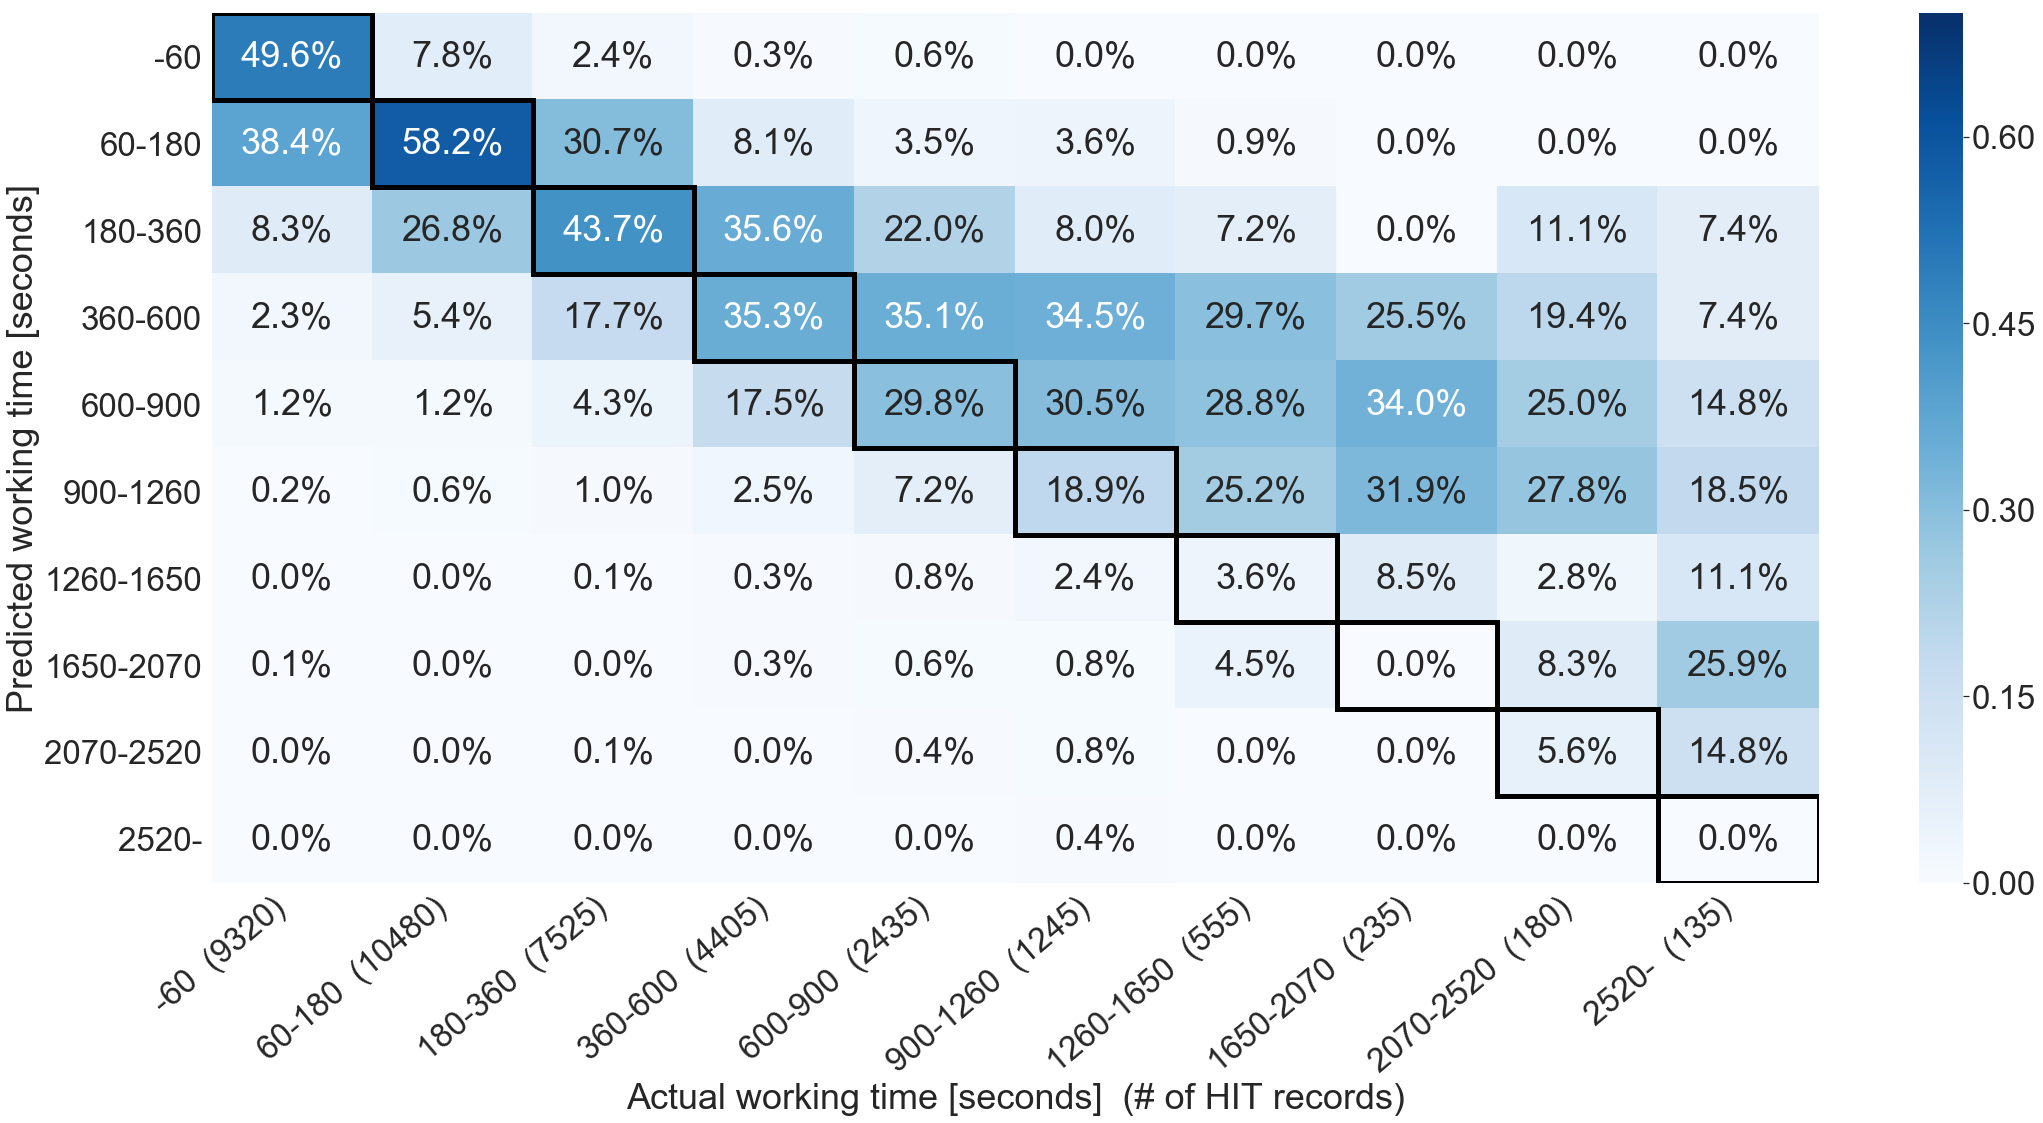

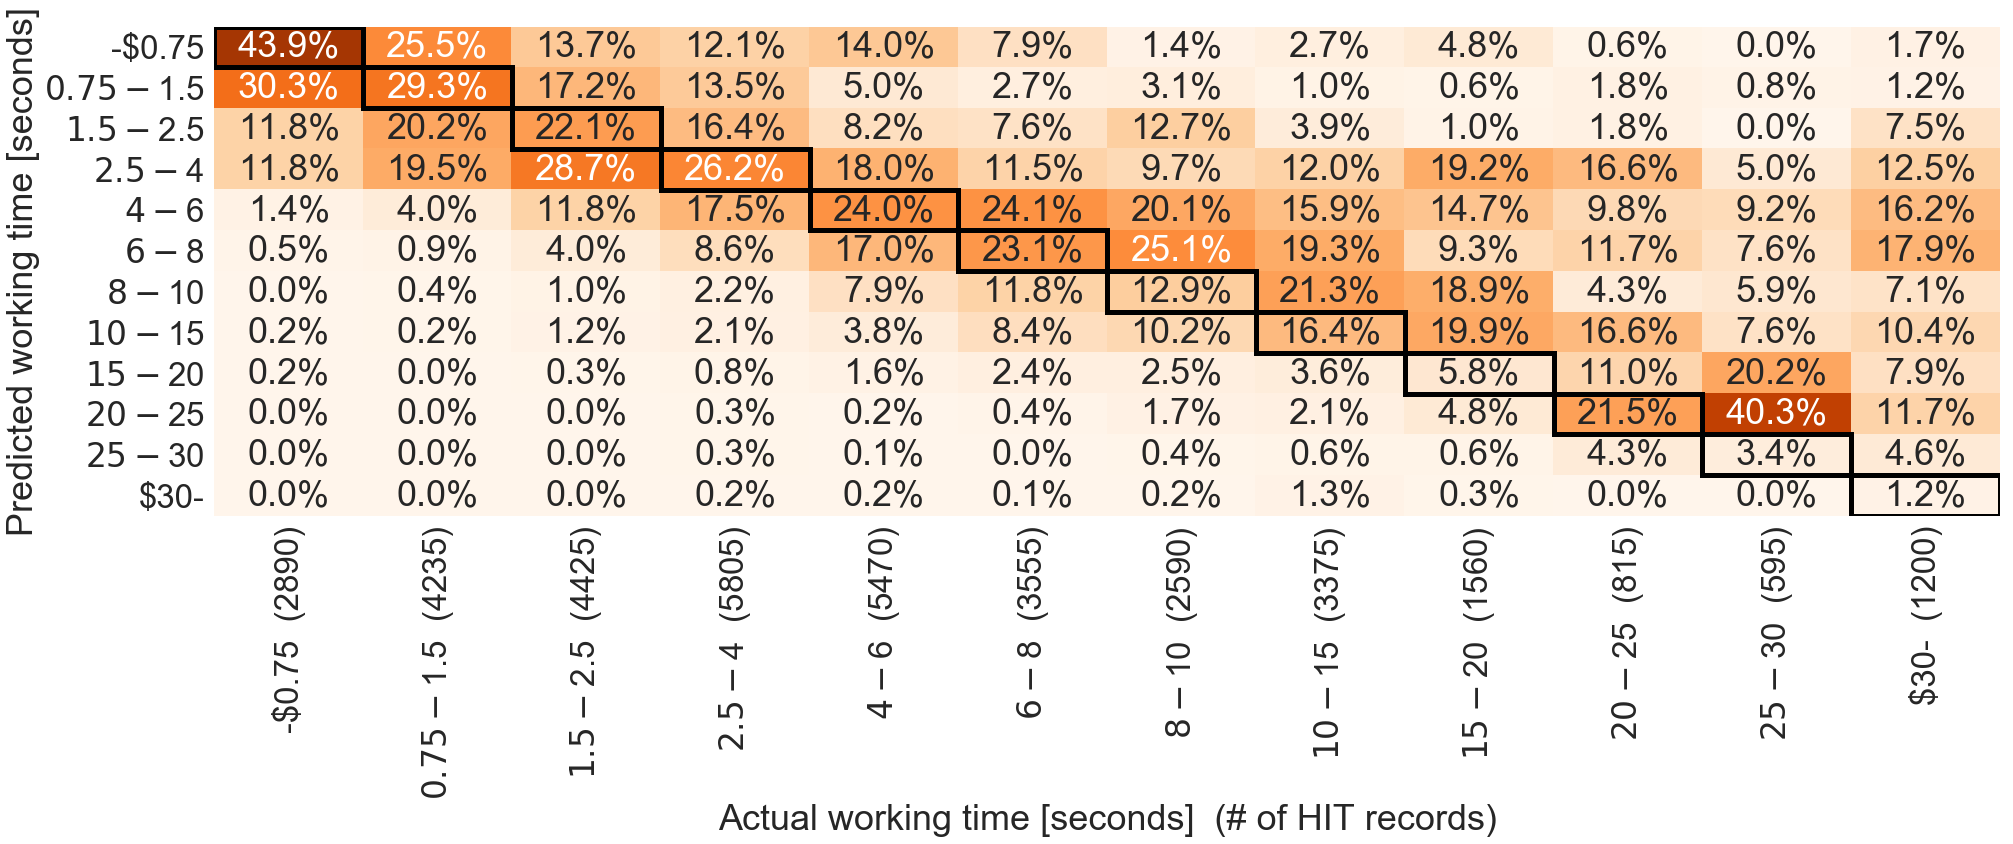

In [178]:
### effective only for regression
# enc_method = "log10"
# enc_method = "log"
# enc_method = "psycho"
enc_method = ""

print("objective: {}, enc_method: {}, drop_grp_duplicates: {}".format(objective,enc_method,drop_group_duplicates))

np_cmx_r_all = None

def get_cat_idx(hw,upperlist):
    for i,c in enumerate(upperlist):
        if hw <= c:
            return i
    return len(upperlist)

worker_ids = df_eval["META:worker_id"].unique()
group_ids = df_eval["META:group_id"].unique()
hit_ids = df_eval["META:hit_id"].unique()

wt_error_plots = []
hw_error_plots = []

wtmin = 5
wtmax = 6000
rmin = 0.10
rmax = 100.0

cmap = plt.get_cmap("jet")

np_cmx_sum_all = None
metrics_sum_all = { "mae": 0, "mape": 0 }

itr = 5

bad_pred_score_h = {"mae": {}, "mape": {}}
bad_pred_score_h["mae"] = {hid:0 for hid in hit_ids}
bad_pred_score_h["mape"] = {hid:0 for hid in hit_ids}

bad_pred_score_w = {"mae": {}, "mape": {}}
bad_pred_score_w["mae"] = {wid:0 for wid in worker_ids}
bad_pred_score_w["mape"] = {wid:0 for wid in worker_ids}

@jit
def lgb_train_func(lgbm_params, lgb_train, valid_sets, verbose_eval, categorical_features, evaluation_results):
    return lgb.train(lgbm_params, lgb_train, valid_sets=valid_sets, verbose_eval=verbose_eval, categorical_feature=categorical_features, fobj=myfobj)
#     return lgb.train(lgbm_params, lgb_train, valid_sets=valid_sets, verbose_eval=verbose_eval, categorical_feature=categorical_features)

cnt_ltp = 0
cnt_mtp = 0

for i in range(itr):
    print("iteration {}".format(i))
    df_cmx_all = []
    mae_all = []
    np_cmx_r = np.zeros((len(r_cls),len(r_cls)),dtype="int16")
    metrics_all = { "mae": [], "mape": [] }
    
#     kf = model_selection.KFold(n_splits=cv,shuffle=True)

#     for tri, tei in kf.split(worker_ids):
#         worker_ids_tr = worker_ids[tri]
#         worker_ids_te = worker_ids[tei]
        
#         idx_tr = df_eval["META:worker_id"].isin(worker_ids_tr)
#         idx_te = df_eval["META:worker_id"].isin(worker_ids_te)
        
    for tri, tei in kf.split(group_ids):
        group_ids_tr = group_ids[tri]
        group_ids_te = group_ids[tei]
        
        idx_tr = df_eval["META:group_id"].isin(group_ids_tr)
        idx_te = df_eval["META:group_id"].isin(group_ids_te)

        hit_ids_train = df_eval.loc[idx_tr,"META:hit_id"]
        hit_ids_test = df_eval.loc[idx_te,"META:hit_id"]
        
        X_train = df[idx_tr]
        X_test = df[idx_te]

        y_train = df_eval.loc[idx_tr,"PHS:work_time"]
        y_test = df_eval.loc[idx_te,"PHS:work_time"]

        y_test_real = y_test.apply(lambda x: x)
        if objective=="multiclass":
            y_train = y_train.apply(lambda x: categorize_work_time_by_idx(work_time_upper,x))
            y_test = y_test.apply(lambda x: categorize_work_time_by_idx(work_time_upper,x))
        elif objective=="regression":    
            y_train = y_train.apply(lambda x: encode_val(x,enc_method))
            y_test = y_test.apply(lambda x: encode_val(x,enc_method))

        lgb_train = lgb.Dataset(X_train, y_train)
        lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)


        ### TRAIN
        evaluation_results = {}
        model = lgb_train_func(lgbm_params, lgb_train, lgb_eval, False, categorical_features, evaluation_results)
#         model = lgb.train(lgbm_params, lgb_train, valid_sets=lgb_eval, verbose_eval=False, categorical_feature=categorical_features)

        print(evaluation_results)

        ### TEST
        y_pred = list(model.predict(X_test, num_iteration=model.best_iteration))
        
        @jit
        def cnt_ltp_mtp(y_test,y_pred):
            cnt_ltp = 0
            cnt_mtp = 0
            for y in zip(y_test,y_pred):
                if y[0]<y[1]:
                    cnt_ltp += 1
                else:
                    cnt_mtp += 1
            return cnt_ltp,cnt_mtp
        
        cnt_ltp_, cnt_mtp_ = cnt_ltp_mtp(y_test,y_pred)
        cnt_ltp += cnt_ltp_
        cnt_mtp += cnt_mtp_
                    
        mae = mean_absolute_error(y_test, y_pred)
        mape = mean_absolute_percentage_error(y_test, y_pred)
        metrics_all["mae"].append(mae)
        metrics_all["mape"].append(mape)
#         for hid in hit_ids_test:
#             bad_pred_score_h["mae"][hid] += mae
#             bad_pred_score_h["mape"][hid] += mape
#         for wid in worker_ids_te:
#             bad_pred_score_w["mae"][wid] += mae
#             bad_pred_score_w["mape"][wid] += mape
        
        ### results in heatmap
        if objective=="multiclass":
            y_pred_max = np.argmax(y_pred, axis=1)
            results = pd.DataFrame({"data":hit_ids_test, "y_test_real": y_test_real, "y_test":y_test, "y_pred_conf":y_pred, "y_pred":y_pred_max})
            results["y_test_cls"] = results["y_test_real"].apply(lambda x: cls[x])
            results["y_pred_cls"] = results["y_pred"].apply(lambda x: cls[x])
        elif objective=="regression":
            results = pd.DataFrame({"data":hit_ids_test, "y_test_real": y_test_real, "y_test":[decode_val(y,enc_method) for y in y_test], "y_pred":[decode_val(y,enc_method) for y in y_pred]})
            results["y_test_cls"] = results["y_test_real"].apply(lambda x: cls[categorize_work_time_by_idx(work_time_upper,x)])
            results["y_pred_cls"] = results["y_pred"].apply(lambda x: cls[categorize_work_time_by_idx(work_time_upper,x)])

        df_cmx, hit_ids_data = draw_pred_result_heatmap(results,cls)
        df_cmx_all.append(df_cmx)

        # If "split", result contains numbers of times the feature is used in a model.
        # If "gain", result contains total gains of splits which use the feature.
        feature_importance = model.feature_importance(importance_type="split")
        topN_features = pd.DataFrame({"name":list(X_train.columns), "importance":feature_importance}).sort_values("importance",ascending=True)

        for i,row in enumerate(hit_ids_data):
            for j,elem in enumerate(row):
                if len(elem)>0:
                    topN_features_name = list(reversed(topN_features["name"].tolist()))
                    topN_features_name.append("PHS:work_time")
                    hits_each = df.loc[df_eval["META:hit_id"].isin(elem),topN_features_name]
                    for hid in elem:
                        reward = df.loc[df_eval["META:hit_id"]==hid,"META:reward"].values[0]
                        reach = results.loc[results["data"]==hid]
                        y_test = reach["y_test"].values[0]
                        y_pred = reach["y_pred"].values[0]
                        hw_test = reward/y_test*3600
                        hw_pred = reward/y_pred*3600
                        hw_test_idx = get_cat_idx(hw_test,reward_upper)
                        hw_pred_idx = get_cat_idx(hw_pred,reward_upper)
                        np_cmx_r[hw_test_idx,hw_pred_idx] += 1
                        if hw_test>rmin and hw_test<=rmax:
                             hw_error_plots.append((hw_test,((hw_pred-hw_test)/hw_test)*100,get_cat_idx(y_test,work_time_upper)/10))
                        wt_error_plots.append((y_test,y_pred,get_cat_idx(abs(hw_test-hw_pred),[2.00,4.00,6.00,8.00,10.00,15.00,20.00,30.00])/9))

    np_cmx_sum = sum([df.values for df in df_cmx_all])
    if np_cmx_sum_all is not None:
        np_cmx_sum_all = np_cmx_sum_all + np_cmx_sum
    else:
        np_cmx_sum_all = np_cmx_sum

    if np_cmx_r_all is not None:
        np_cmx_r_all = np_cmx_r_all + np_cmx_r
    else:
        np_cmx_r_all = np_cmx_r
        
    for key,metrics in metrics_all.items():
        metrics_sum_all[key] += sum(metrics)
        
print(cnt_ltp,cnt_mtp,cnt_ltp/(cnt_ltp+cnt_mtp))
        
df_cmx, df_cmx_perc = get_df_cmx_with_perc(np_cmx_sum_all,cls)
draw_heatmap(df_cmx_perc, figsize=(36,16), cbar=True, fmt=".1%", vmax=0.7, annot=True)
plt.xticks(rotation=40,ha="right")

df_cmx_r, df_cmx_r_perc = get_df_cmx_with_perc(np_cmx_r_all,r_cls)
draw_heatmap(df_cmx_r_perc, cmap="Oranges", fmt=".1%", vmax=0.5)

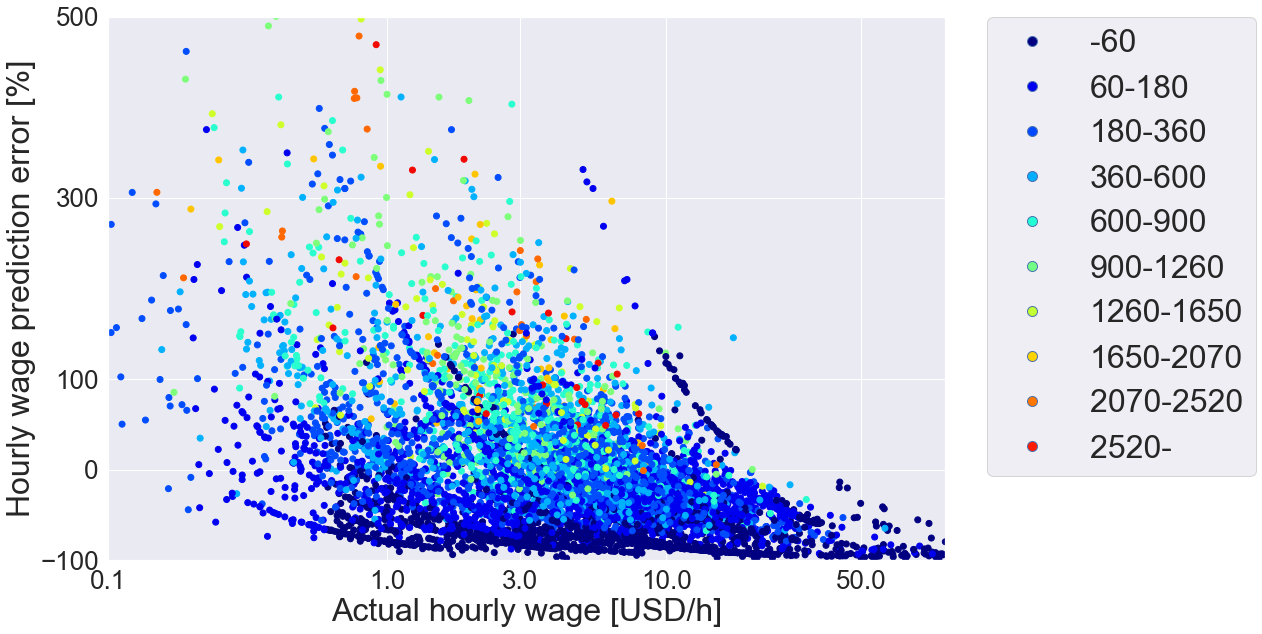

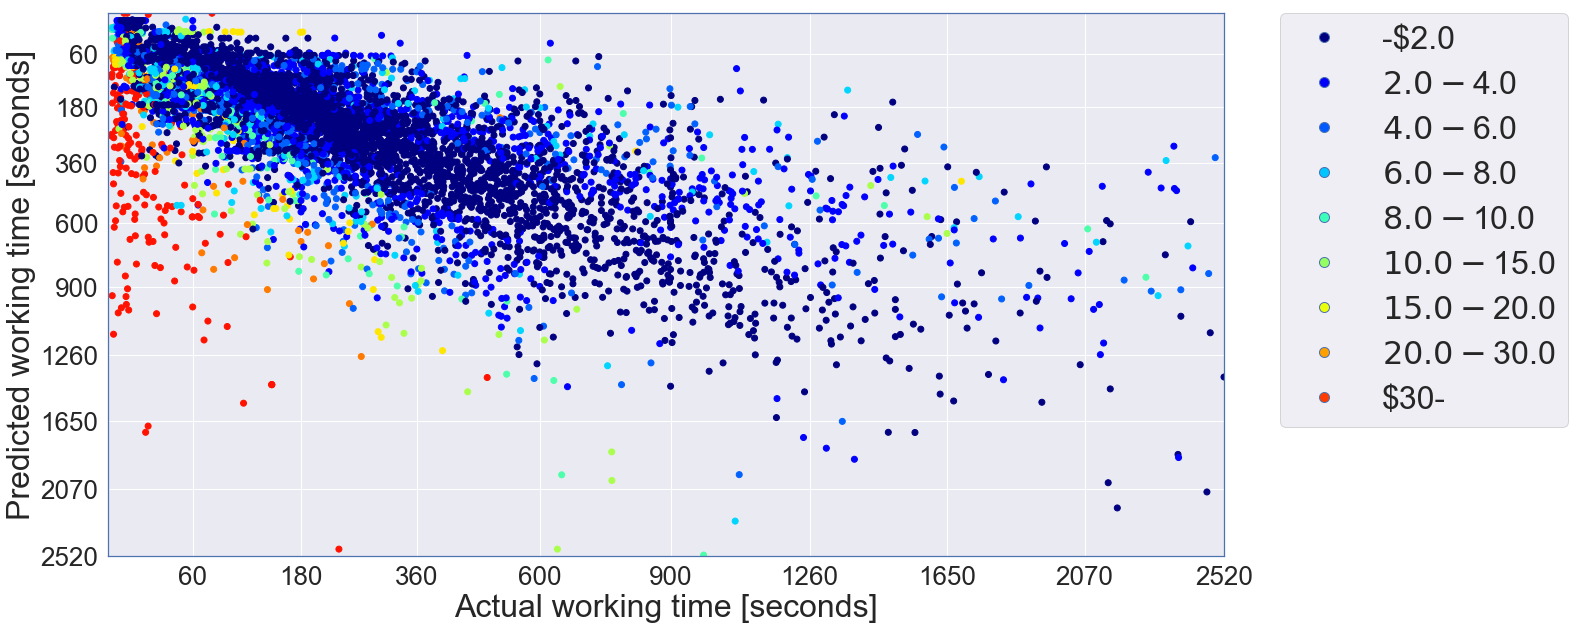

In [9]:
# print(list(zip(*hw_error_plots)))
# c = list(zip(*hw_error_plots))[2]
# vmax = max(c)

# random.shuffle(hw_error_plots)
random.shuffle(wt_error_plots)

fig = plt.figure(figsize=(15,10))
# ax = fig.add_subplot(111, projection='3d')
ax = fig.add_subplot(111)
ax.scatter(list(zip(*hw_error_plots))[0],list(zip(*hw_error_plots))[1],color=cmap(list(zip(*hw_error_plots))[2]),vmin=0.0,vmax=1.0)
ax.set_xlim(rmin,rmax)
ax.set_ylim(-100,500)
ax.set_xlabel("Actual hourly wage [USD/h]",fontsize=32)
ax.set_ylabel("Hourly wage prediction error [%]",fontsize=32)
ax.set_xscale("log", basex=2)
ax.set_xticks([0.10,1.0,3.0,10,50])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.tick_params(labelsize=26)
ax.set_yticks([-100,0,100,300,500])
matplotlib.rc('axes',edgecolor='b')

legends = []
for i,c in enumerate(cls):
    legends.append(Line2D([0], [0], marker='o', linestyle="", label=c, markerfacecolor=cmap(i*25), markersize=10))
ax.legend(handles=legends, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=32)


# print(wt_error_plots)

from numpy import ma
from matplotlib import scale as mscale
from matplotlib import transforms as mtransforms
from matplotlib.ticker import Formatter, FixedLocator

class WTPsychoLatitudeScale(mscale.ScaleBase):
    name = 'psycho'

    def __init__(self, axis, *, thresh=999999, **kwargs):
#         super(WTPsychoLatitudeScale,self).__init__(axis)
#         if thresh >= 999999:
#             raise ValueError("thresh must be less than pi/2")
        self.thresh = thresh

    def get_transform(self):
        return self.WTPsychoLatitudeTransform(self.thresh)
    
    def set_default_locators_and_formatters(self, axis):
        """
        Override to set up the locators and formatters to use with the
        scale.  This is only required if the scale requires custom
        locators and formatters.  Writing custom locators and
        formatters is rather outside the scope of this example, but
        there are many helpful examples in ``ticker.py``.

        In our case, the Mercator example uses a fixed locator from
        -90 to 90 degrees and a custom formatter class to put convert
        the radians to degrees and put a degree symbol after the
        value::
        """
        class DegreeFormatter(Formatter):
            def __call__(self, x, pos=None):
                return "%d\N{DEGREE SIGN}" % np.degrees(x)
            
        pass

#         axis.set_major_locator(FixedLocator(
#             np.radians(np.arange(-90, 90, 10))))
#         axis.set_major_formatter(DegreeFormatter())
#         axis.set_minor_formatter(DegreeFormatter())
    
    class WTPsychoLatitudeTransform(mtransforms.Transform):
        input_dims = 1
        output_dims = 1
        is_separable = True
        has_inverse = True

        def __init__(self, thresh):
            mtransforms.Transform.__init__(self)
            self.thresh = thresh

        def transform_non_affine(self, x):
            [a,b,c] = [ 137.78235923,  124.37127684, -587.36784393]
            K = 100
            precision = 0.1
            return (np.exp(-c/a)*K*expi(np.log(x+b)+c/a))/a
        
        def inverted(self):
            return WTPsychoLatitudeScale.InvertedWTPsychoLatitudeTransform(self.thresh)
            
    class InvertedWTPsychoLatitudeTransform(mtransforms.Transform):
        input_dims = 1
        output_dims = 1
        is_separable = True
        has_inverse = True

        def __init__(self, thresh):
            mtransforms.Transform.__init__(self)
            self.thresh = thresh

        def transform_non_affine(self, x):
            [a,b,c] = [ 137.78235923,  124.37127684, -587.36784393]
            K = 100
            precision = 0.1
            y=x
            xrange = range(0,10000,100)
            xrange2 = np.arange(0,100,precision)
            x_ = -1
            for xr in xrange:
                if psychological_working_time(xr,"enc")>y:
                    x_ = xr-100
                    break

            pprev = 0
            for xr in xrange2:
                x = x_+xr
                p = psychological_working_time(x,"enc")
                if p>y:
                    if abs(y-pprev)<abs(y-p):
                        return x-precision
                    else:
                        return x
                else:
                    pprev = p

        def inverted(self):
            return WTPsychoLatitudeScale.WTPsychoLatitudeTransform(self.thresh)
            

mscale.register_scale(WTPsychoLatitudeScale)


fig = plt.figure(figsize=(20,10))
# ax = fig.add_subplot(111, projection='3d')
ax = fig.add_subplot(111)
ax.scatter(list(zip(*wt_error_plots))[0],list(zip(*wt_error_plots))[1],color=cmap(list(zip(*wt_error_plots))[2]),vmin=0.0,vmax=1.0)
# ax.scatter(list(zip(*wt_error_plots))[0],list(zip(*wt_error_plots))[1],color=cmap(list(zip(*wt_error_plots))[2]))
ax.set_xlim(1,2500)
ax.set_ylim(1,2500)
ax.set_xlabel("Actual working time [seconds]",fontsize=32)
ax.set_ylabel("Predicted working time [seconds]",fontsize=32)
# ax.set_xscale("log", basex=2)
# ax.set_yscale("log", basex=2)
ax.set_xscale("psycho")
ax.set_yscale("psycho")
ax.set_xticks(work_time_upper)
ax.set_yticks(work_time_upper)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.tick_params(labelsize=26)
# ax.set_yticks([-100,0,100,300,500,800])
matplotlib.rc('axes',edgecolor='b')
plt.gca().invert_yaxis()

# for w in wt_error_plots:
#     print(w[2])

rd_cls = []
rd_upper = [2.00,4.00,6.00,8.00,10.00,15.00,20.00,30.00]
for i,t in enumerate(rd_upper):
    if i==0:
        reward_min = ""
    else:
        reward_min = "${}".format(rd_upper[i-1])
    reward_max = "${}".format(t)
    rd_cls.append("{}-{}".format(reward_min,reward_max))
rd_cls.append("${}-".format(reward_upper[-1]))

legends = []
for i,c in enumerate(rd_cls):
    legends.append(Line2D([0], [0], marker='o', linestyle="", label=c, markerfacecolor=cmap(i*27), markersize=10))
ax.legend(handles=legends, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=32)


# print(list(zip(*hw_error_plots))[2])

# for key,metrics in metrics_sum_all.items():
#     print("{}: {}".format(key,metrics/itr))

In [26]:
[l/30 for l in list(zip(*wt_error_plots))[2]]

[0.0037037037037037034,
 0.0,
 0.0,
 0.0,
 0.0037037037037037034,
 0.0,
 0.0,
 0.0037037037037037034,
 0.0,
 0.007407407407407407,
 0.007407407407407407,
 0.0037037037037037034,
 0.0,
 0.0,
 0.0,
 0.0037037037037037034,
 0.029629629629629627,
 0.01111111111111111,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0037037037037037034,
 0.0,
 0.029629629629629627,
 0.0,
 0.01851851851851852,
 0.007407407407407407,
 0.0037037037037037034,
 0.0,
 0.0,
 0.0,
 0.007407407407407407,
 0.0037037037037037034,
 0.0,
 0.0037037037037037034,
 0.0,
 0.0037037037037037034,
 0.0,
 0.0,
 0.007407407407407407,
 0.025925925925925925,
 0.0037037037037037034,
 0.0037037037037037034,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0037037037037037034,
 0.007407407407407407,
 0.01851851851851852,
 0.01111111111111111,
 0.0,
 0.02222222222222222,
 0.0,
 0.0037037037037037034,
 0.0,
 0.0,
 0.0,
 0.01111111111111111,
 0.01851851851851852,
 0.0,
 0.007407407407407407,
 0.007407407407407407,
 0.0,
 0.0,
 0.0037037037037037034,
 0.0,
 0.0,
 0.0,

In [27]:
addcols = [5,0,3,6,7,6,1,0,8,7]
# df_cmx_perc = df_cmx_perc.rename(index=str, columns={c:c[:-1]+str(addcols[i])+")" for i,c in enumerate(df_cmx_perc.columns)})

# df_cmx_perc_fixed = df_cmx_perc.rename(index=str, columns={c:c[:-2]+")" for c in df_cmx_perc.columns})
# df_cmx_perc_r_fixed = df_cmx_r_perc.rename(index=str, columns={c:c[:-2]+")" for c in df_cmx_r_perc.columns})
# draw_heatmap(df_cmx_perc_fixed, fmt=".1%", vmax=0.7)
draw_heatmap(df_cmx_perc_fixed, figsize=(18,8), cbar=True, fmt=".1%", vmax=0.7, annot=True)
plt.xticks(rotation=40,ha="right")

# plt.title("Prediction Results of HIT Working Times\n",fontsize=48)
draw_heatmap(df_cmx_perc_r_fixed, cmap="Oranges", fmt=".1%", vmax=0.5)
plt.title("Prediction Results of HIT Hourly Wages\n",fontsize=48)
plt.xlabel("Actual Hourly Wage [USD] (# of HIT records)")
plt.ylabel("Predicted Hourly Wage [USD]")

NameError: name 'df_cmx_perc_fixed' is not defined

In [ ]:
import chainer
import chainer.functions as F
import chainer.links as L
from chainer import training
from chainer.training import extensions

from IPython.core.display import display, HTML
from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib.patches import Rectangle


### from tutorials (https://docs.chainer.org/en/stable/glance.html)

# train_iter = ch.iterators.SerialIterator(train, 100)
# test_iter = ch.iterators.SerialIterator(
#     test, 100, repeat=False, shuffle=False)

# def MLP(n_units, n_out):
#     layer = ch.Sequential(L.Linear(n_units), F.relu)
#     model = layer.repeat(2)
#     model.append(L.Linear(n_out))

#     return model

# model = L.Classifier(
#     MLP(44, 1), lossfun=F.sigmoid_cross_entropy, accfun=F.binary_accuracy)

# optimizer = ch.optimizers.SGD().setup(model)

# updater = training.StandardUpdater(train_iter, optimizer, device=-1)

# trainer = training.Trainer(updater, (50, 'epoch'), out='result')

# trainer.extend(extensions.Evaluator(test_iter, model, device=-1))

# trainer.extend(extensions.dump_graph('main/loss'))

# trainer.extend(extensions.snapshot(), trigger=(20, 'epoch'))

# trainer.extend(extensions.LogReport())

# if extensions.PlotReport.available():
#     trainer.extend(
#         extensions.PlotReport(['main/loss', 'validation/main/loss'],
#                               'epoch', file_name='loss.png'))
#     trainer.extend(
#         extensions.PlotReport(
#             ['main/accuracy', 'validation/main/accuracy'],
#             'epoch', file_name='accuracy.png'))
    
# trainer.extend(extensions.PrintReport(
#     ['epoch', 'main/loss', 'validation/main/loss',
#      'main/accuracy', 'validation/main/accuracy', 'elapsed_time']))

# trainer.run()

# x, t = test[np.random.randint(len(test))]

# predict = model.predictor(x[None]).data
# predict = predict[0][0]

# if predict >= 0:
#     print('Predicted Poisonous, Actual ' + ['Edible', 'Poisonous'][t[0]])
# else:
#     print('Predicted Edible, Actual ' + ['Edible', 'Poisonous'][t[0]])

###

### from https://www.case-k.jp/entry/2018/08/26/191628

class NN(chainer.Chain):

    # モデルの構造
    def __init__(self, n_mid_units=5, n_out=2):
        super().__init__()
        with self.init_scope():
            self.fc1 = L.Linear(64)  
            self.fc2 = L.Linear(32)
#             self.fc3 = L.Linear(16)
#             self.fc4 = L.Linear(8)

    # 順伝播
    def __call__(self, x):
        u1 = self.fc1(x)
        z1 = F.relu(u1)
        u2 = self.fc2(z1)
#         z2 = F.relu(u2)
#         u3 = self.fc3(z2)
#         z3 = F.relu(u3)
#         u4 = self.fc4(z3)
        return u2
    
nn = NN(n_mid_units=8,n_out=8)
model = L.Classifier(nn)

optimizer = chainer.optimizers.SGD() 
optimizer.setup(model)
    
###

cv = 4
kf = model_selection.KFold(n_splits=cv,shuffle=True)

# drop_group_duplicates = True
drop_group_duplicates = False

df_ = df.copy()
if drop_group_duplicates:
    df_ = df.drop_duplicates("META:group_id")
    
print("drop_grp_duplicates: {}".format(drop_group_duplicates))

### make working time categories
# work_time_upper = [8,15,30,45,60,90,120,150,180,240,300,420,600,1200]
# work_time_upper = [8,15,30,45,60,80,100,120,140,170,200,240,280,340,420,600,800,1200]
work_time_upper = [30,60,120,180,300,600,1200]
cls = []
for i,t in enumerate(work_time_upper):
    if i==0:
        work_time_min = ""
    else:
        work_time_min = work_time_upper[i-1]
    work_time_max = t
    cls.append("{}-{}".format(work_time_min,work_time_max))
cls.append("{}-".format(work_time_upper[-1]))

worker_ids = df_["META:worker_id"].unique()

for tri, tei in kf.split(worker_ids):


    ### prepare data
    worker_ids_tr = worker_ids[tri]
    worker_ids_te = worker_ids[tei]

    train_all = df_.loc[df_["META:worker_id"].isin(worker_ids_tr)]
    test_all = df_.loc[df_["META:worker_id"].isin(worker_ids_te)]

    hit_ids_train = train_all["META:hit_id"]
    hit_ids_test = test_all["META:hit_id"]

    X_train = drop_contains(train_all, ["META:hit_id","META:worker_id","META:group_id","PHS:work_time"])
    X_test = drop_contains(test_all, ["META:hit_id","META:worker_id","META:group_id","PHS:work_time"])

    y_train = train_all["PHS:work_time"]
    y_test = test_all["PHS:work_time"]

    y_train = y_train.apply(lambda x: categorize_work_time_by_idx(work_time_upper,x))
    y_test = y_test.apply(lambda x: categorize_work_time_by_idx(work_time_upper,x))

    
    X_train = np.nan_to_num(np.array(X_train.astype('float32')))
    X_test = np.nan_to_num(np.array(X_test.astype('float32')))
    y_train = np.array(y_train.astype('int32'))
    y_test = np.array(y_test.astype('int32'))
        
    train = list(zip(X_train, y_train))
    test = list(zip(X_test, y_test))
    
    print(X_train[0])
        
    batchsize = 10
    train_iter = chainer.iterators.SerialIterator(train, batchsize)
    test_iter  = chainer.iterators.SerialIterator(test,  batchsize, repeat=False, shuffle=False)

    updater = training.StandardUpdater(train_iter, optimizer, device=-1)

    # エポックの数
    epoch = 50

    # trainerの宣言
    trainer = training.Trainer(updater, (epoch, 'epoch'), out='result/cancer')

    # 検証データで評価
    trainer.extend(extensions.Evaluator(test_iter, model, device=-1))

    # 学習の経過をtrainerのoutで指定したフォルダにlogというファイル名で記録する
    trainer.extend(extensions.LogReport(trigger=(1, 'epoch')))

    # １エポックごと（trigger）に、trainデータに対するlossと、testデータに対するloss、経過時間（elapsed_time）を標準出力させる
    trainer.extend(extensions.PrintReport(['epoch', 'main/accuracy', 'validation/main/accuracy', 'main/loss', 'validation/main/loss', 'elapsed_time']), trigger=(1, 'epoch'))

    # 実行
    trainer.run()

    with open('result/cancer/log') as f:
        logs = json.load(f)
        results = pd.DataFrame(logs)

    # 結果の確認
    results

#     ### TEST
#     y_pred = list(model.predict(X_test, num_iteration=model.best_iteration))



#     ### results in heatmap
#     if objective=="multiclass":
#         y_pred_max = np.argmax(y_pred, axis=1)
#         results = pd.DataFrame({"data":hit_ids_test, "y_test":y_test, "y_pred_conf":y_pred, "y_pred":y_pred_max})
#         results["y_test_cls"] = results["y_test"].apply(lambda x: cls[x])
#         results["y_pred_cls"] = results["y_pred"].apply(lambda x: cls[x])
#     elif objective=="regression":
#         results = pd.DataFrame({"data":hit_ids_test, "y_test":[decode_val(y,enc_method) for y in y_test], "y_pred":[decode_val(y,enc_method) for y in y_pred]})
#         results["y_test_cls"] = results["y_test"].apply(lambda x: cls[categorize_work_time_by_idx(work_time_upper,x)])
#         results["y_pred_cls"] = results["y_predal"].apply(lambda x: cls[categorize_work_time_by_idx(work_time_upper,x)])

#     df_cmx, hit_ids_data = draw_pred_result_heatmap(results)
#     df_cmx_all.append(df_cmx)

#     # If "split", result contains numbers of times the feature is used in a model.
#     # If "gain", result contains total gains of splits which use the feature.
#     feature_importance = model.feature_importance(importance_type="split")
#     topN_features = pd.DataFrame({"name":list(X_train.columns), "importance":feature_importance}).sort_values("importance",ascending=True)[-15:]
# #         plt.figure()
# #         sns.set(font_scale=1.0)
# #         topN_features.plot.barh(x="name", y="importance")

#     for i,row in enumerate(hit_ids_data):
#         for j,elem in enumerate(row):
#             if len(elem)>0:
#                 topN_features_name = list(reversed(topN_features["name"].tolist()))
#                 topN_features_name.append("PHS:work_time")
#                 hits_each = df_.loc[df_["META:hit_id"].isin(elem),topN_features_name]
# #                 print("Actual: {}, Pred: {}".format(cls[i], cls[j]))
# #                 display(hits_each)

# #                 html_str_list = []
# #                 for hit_id in elem:
# #                     html_str_list.append("<a href='../csv/chun/html/{}.html' target='_blank'>{}</a>".format(hit_id,hit_id))
# #                 display(HTML(", ".join(html_str_list)))
# #     break




# df_cmx, df_cmx_perc = get_df_cmx_with_perc(np_cmx_sum_all)
# draw_heatmap(df_cmx_perc)

In [ ]:
hoge=np.ones((2,2))
fuga=np.array([[1,2],[3,4]])
hoge+fuga

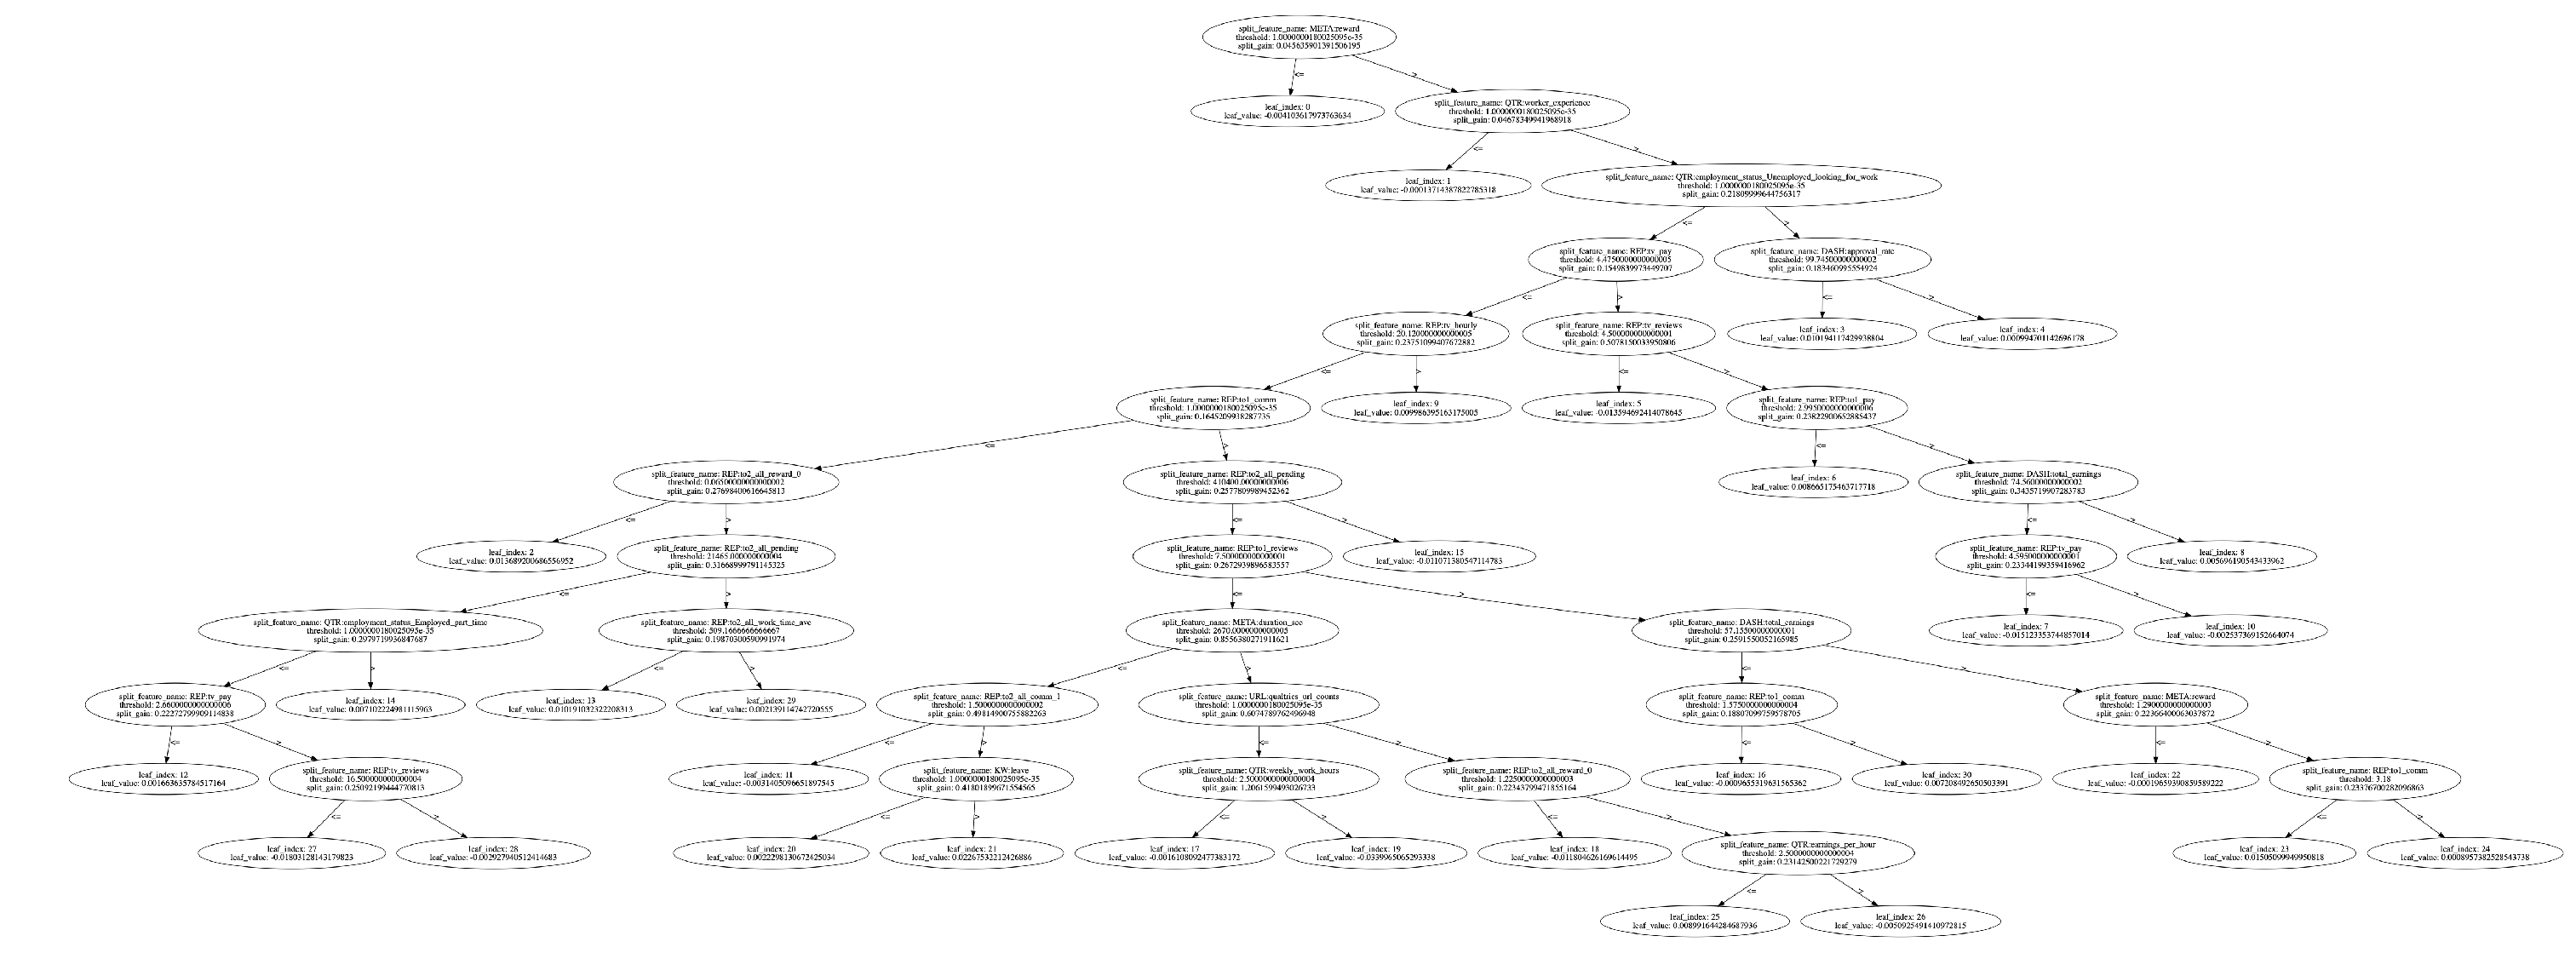

In [54]:
model = lgb.Booster(model_file='lightgbm_model.txt')

ax = lgb.plot_tree(model, tree_index=99, figsize=(100, 20), show_info=['split_gain'])
plt.show()

In [140]:
df = pd.read_csv("turkscanner_all.csv")
df_html = pd.read_csv("../csv/chun2/appenddata.csv", escapechar="\\", encoding="latin1")
df_meta = pd.read_csv("../csv/chun2/scraper_hit.csv", escapechar="\\", encoding="latin1")
hit_ids = df["hit_id"]

In [152]:
df_html_sel = df_html.loc[df_html["hit_id"].isin(hit_ids.tolist()),["hit_id","TXT:inner_html"]]
df_html_sel.to_csv("turkscanner_html.csv")
# print(hit_ids)
# print(df_meta["hit_id"])
df_meta_sel = df_meta.loc[df_meta["id"].isin(hit_ids.tolist()),:]
# df_meta_sel = df_meta.loc[hit_ids,:]
df_meta_sel.to_csv("turkscanner_meta.csv")

In [21]:
allsum = 1864+2096+1505+881+487+249+111+47+36+27
allsum_half1 = 1864+2096+1505+881+487
allsum_half2 = 249+111+47+36+27

log_pri = 0.595*1864+0.599*2096+0.490*1505+0.327*881+0.216*487+0.102*249+0.031*111+0.013*47+0.014*36+0.011*27
log_pri_half1 = 0.595*1864+0.599*2096+0.490*1505+0.327*881+0.216*487
log_pri_half2 = 0.102*249+0.031*111+0.013*47+0.014*36+0.011*27
log_sec = 0.936*1864+0.955*2096+0.937*1505+0.860*881+0.618*487+0.396*249+0.172*111+0.051*47+0.047*36+0.074*27
log_sec_half1 = 0.936*1864+0.955*2096+0.937*1505+0.860*881+0.618*487
log_sec_half2 = 0.396*249+0.172*111+0.051*47+0.047*36+0.074*27

psy_pri = 0.478*1864+0.565*2096+0.519*1505+0.377*881+0.269*487+0.165*249+0.052*111+0.034*47+0.044*36+0.044*27
psy_pri_half1 = 0.478*1864+0.565*2096+0.519*1505+0.377*881+0.269*487
psy_pri_half2 = 0.165*249+0.052*111+0.034*47+0.044*36+0.044*27
psy_sec = 0.899*1864+0.943*2096+0.942*1505+0.896*881+0.721*487+0.527*249+0.283*111+0.136*47+0.113*36+0.137*27
psy_sec_half1 = 0.899*1864+0.943*2096+0.942*1505+0.896*881+0.721*487
psy_sec_half2 = 0.527*249+0.283*111+0.136*47+0.113*36+0.137*27
print(log_pri/allsum,log_sec/allsum)
print(log_pri_half1/allsum_half1,log_sec_half1/allsum_half1)
print(log_pri_half2/allsum_half2,log_sec_half2/allsum_half2)
print(psy_pri/allsum,psy_sec/allsum)
print(psy_pri_half1/allsum_half1,psy_sec_half1/allsum_half1)
print(psy_pri_half2/allsum_half2,psy_sec_half2/allsum_half2)

log_pri_perc = 0.595+0.599+0.490+0.327+0.216+0.102+0.031+0.013+0.014+0.011
log_sec_perc = 0.936+0.955+0.937+0.860+0.618+0.396+0.172+0.051+0.047+0.074
psy_pri_perc = 0.478+0.565+0.519+0.377+0.269+0.165+0.052+0.034+0.044+0.044
psy_sec_perc = 0.899+0.943+0.942+0.896+0.721+0.527+0.283+0.136+0.113+0.137

# percent average
print(log_pri_perc/10,log_sec_perc/10)
print(psy_pri_perc/10,psy_sec_perc/10)

0.4827555798986717 0.8679964398192523
0.5115341723986535 0.9095851017122787
0.06436382978723404 0.263368085106383
0.46154922634533757 0.8746093386279611
0.48579935606614966 0.9088946290062931
0.1089936170212766 0.3761595744680852
0.2398 0.5045999999999999
0.2547 0.5597000000000001
